In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import PowerTransformer



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [ ]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s, seasonal = args
    try:
          model = SARIMAX(
              endog,
              order=(order[0], d, order[1]),
              seasonal_order=(order[2], D, order[3], s),
              simple_differencing=False
          ).fit(disp=False)
          return (order, model.aic)
    except:
        return None

def optimize_SARIMA_parallel(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6, edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# Seleção de modelo

In [ ]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_3 = df.iloc[:, 2]
serie_3 .head()

,#3
0,0.186657
1,0.176288
2,0.167646
3,0.175423
4,0.209342


# Conjunto de treino

In [ ]:
test = pd.DataFrame()
test["Values"] = serie_3.iloc[-12:]
test['naive_seasonal'] = serie_3.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_3.iloc[-24:-12].mean()

Análise exploratória

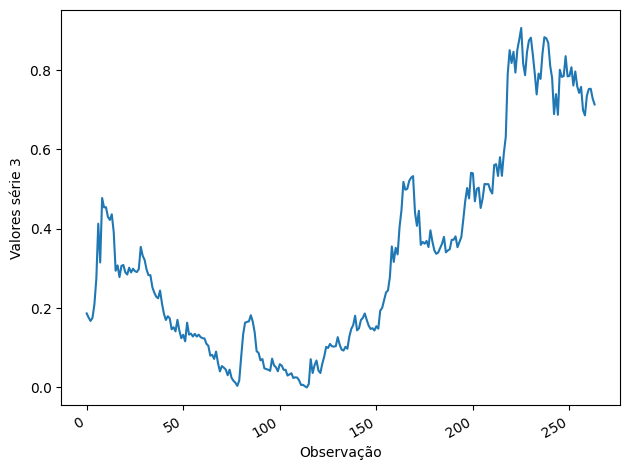

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_3)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 3')

fig.autofmt_xdate()
plt.tight_layout()


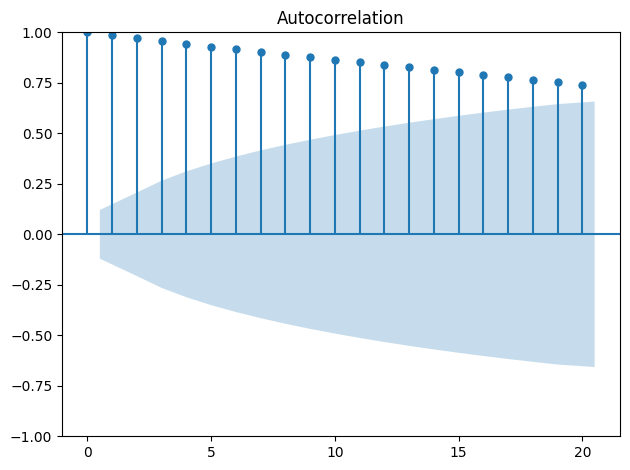

In [ ]:
plot_acf(serie_3, lags=20);

plt.tight_layout()

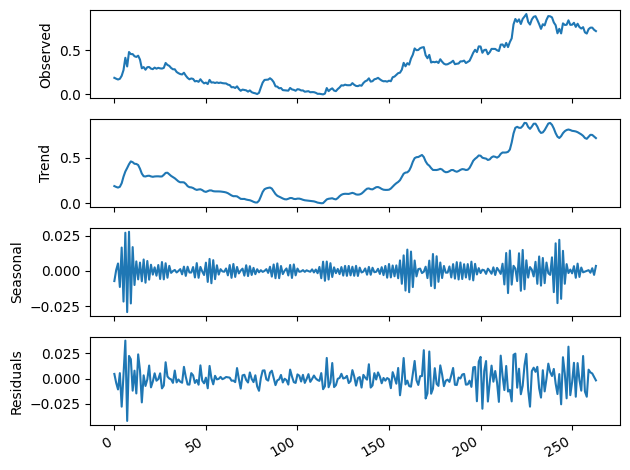

In [ ]:
advanced_decomposition = STL(serie_3,period=2).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

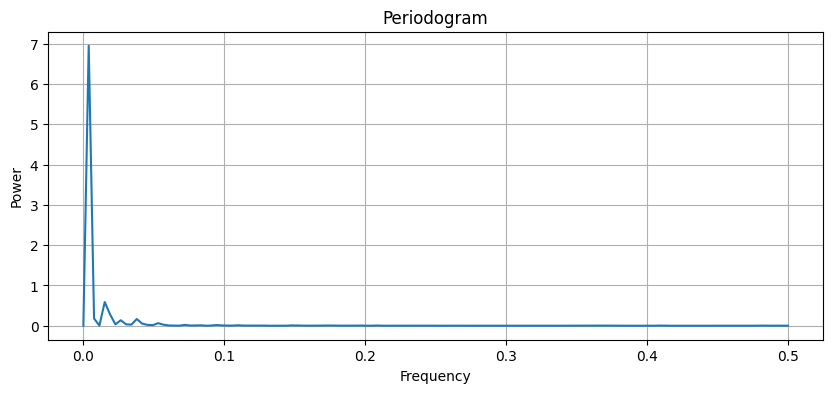

In [ ]:
from scipy.signal import periodogram

freqs, psd = periodogram(serie_3, detrend='linear')
plt.figure(figsize=(10, 4))
plt.plot(freqs, psd)
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.show()


## ARIMA

In [ ]:
check_stationarity(serie_3)

{'adf_stat': np.float64(-10.247035168805061),
 'p_value': np.float64(4.5888407866458195e-18),
 'stationary': True,
 'diffs_needed': 1,
 'seasonal_diffs_needed': 0}

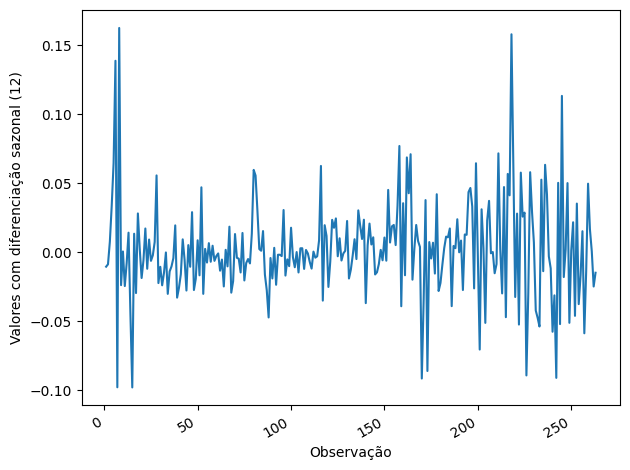

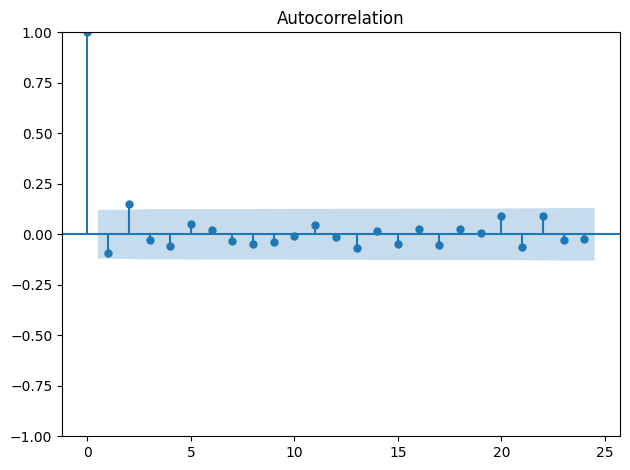

In [ ]:
seasonal_diff = serie_3.diff().dropna()
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

## Treinamento

In [ ]:
train = serie_3[:-12]

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)


```
 from itertools import product

d, D, s = 1, 0, 0
ps = qs = range(0, 12)
Ps = Qs = [0]

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = serie_1[:-12]

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(0,1,2) | AIC = -1409.303068 \\

In [ ]:
train = serie_3[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(2,1,1), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

SARIMA_model = SARIMAX(train_transformed, order=(4,0,3), seasonal_order=(3,1,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 707.717
Date:                Tue, 29 Apr 2025   AIC                          -1407.434
Time:                        17:33:38   BIC                          -1393.332
Sample:                             0   HQIC                         -1401.759
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1503      0.414      0.363      0.717      -0.662       0.962
ar.L2          0.1842      0.051      3.609      0.000       0.084       0.284
ma.L1         -0.1864      0.406     -0.459      0.6

In [ ]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()


### Análise de resíduos

In [ ]:
check_white_noise(ARIMA_model_fit.resid, lags = 250)

{'residuals': {'p_values': 1      0.806979
  2      0.949940
  3      0.990111
  4      0.986408
  5      0.802166
           ...   
  246    0.197883
  247    0.200247
  248    0.162848
  249    0.097140
  250    0.095820
  Name: lb_pvalue, Length: 250, dtype: float64,
  'lags_failed': np.int64(0)},
 'squared_residuals': {'p_values': 1      0.615349
  2      0.878177
  3      0.963554
  4      0.990303
  5      0.986624
           ...   
  246    1.000000
  247    1.000000
  248    1.000000
  249    1.000000
  250    1.000000
  Name: lb_pvalue, Length: 250, dtype: float64,
  'lags_failed': np.int64(0)}}

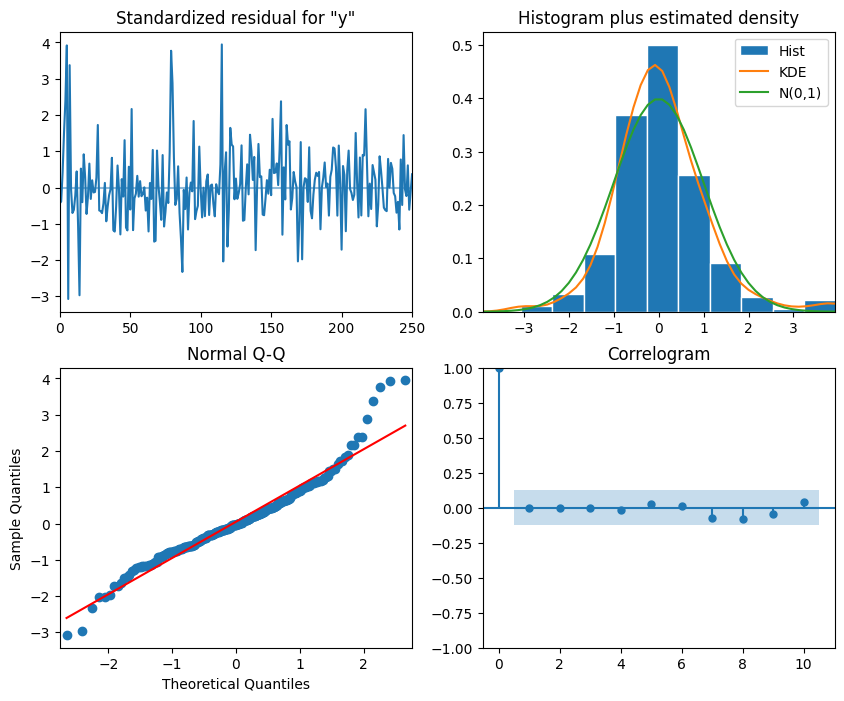

In [ ]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

## Holt-Winters

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_3[:-12]
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)
ES = ExponentialSmoothing(train_transformed,trend='add', damped_trend=True)
ES_fit = ES.fit()
forecast_1 =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()

ES3 = ExponentialSmoothing(train, trend='add')
ES3_fit = ES3.fit()

test["HW"] = forecast_1
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.761342,0.811247,0.774083,0.805407,0.779206,0.806528,0.808558
253,0.796686,0.780094,0.774083,0.809204,0.795790,0.807957,0.811030
254,0.759182,0.689163,0.774083,0.809419,0.831625,0.809102,0.813503
255,0.742633,0.739522,0.774083,0.810154,0.833435,0.810020,0.815975
256,0.757950,0.687543,0.774083,0.810304,0.819962,0.810755,0.818448
257,0.699317,0.800899,0.774083,0.810463,0.808952,0.811344,0.820920
258,0.685945,0.783011,0.774083,0.810514,0.791073,0.811816,0.823393
259,0.735698,0.785106,0.774083,0.810551,0.854218,0.812193,0.825865
260,0.752463,0.835292,0.774083,0.810566,0.880611,0.812495,0.828338
261,0.753111,0.784242,0.774083,0.810575,0.861539,0.812737,0.830810


In [ ]:
ES_fit.summary()

Dep. Variable:,None,No. Observations:,252
Model:,ExponentialSmoothing,SSE,0.053
Optimized:,True,AIC,-2123.006
Trend:,Additive,BIC,-2105.359
Seasonal:,None,AICC,-2122.547
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,17:33:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8812865,alpha,True
smoothing_trend,0.1296317,beta,True


## Theta

In [ ]:
from statsmodels.tsa.forecasting.theta import ThetaModel

# Fit the Theta model
theta_model = ThetaModel(train,difference=True,period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
test["Theta"] = theta_forecast

# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)
#10,06

                              ThetaModel Results                              
Dep. Variable:                     #3   No. Observations:                  252
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:               Additive
Time:                        17:33:39   Period:                             12
Sample:                             0                                         
                                  252                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    0.002335774846934015
alpha   0.9388340912296157
--------------------------
Forecast: 252    0.807253
253    0.808421
254    0.809589
255    0.810757
256    0.811925
257    0.813093
258    0.814261
259    0.815429
260    0.816597
261    0.817764
262    0.818932
263    0.820100
Name: forecast, dtype: float64


## Visualização das predições


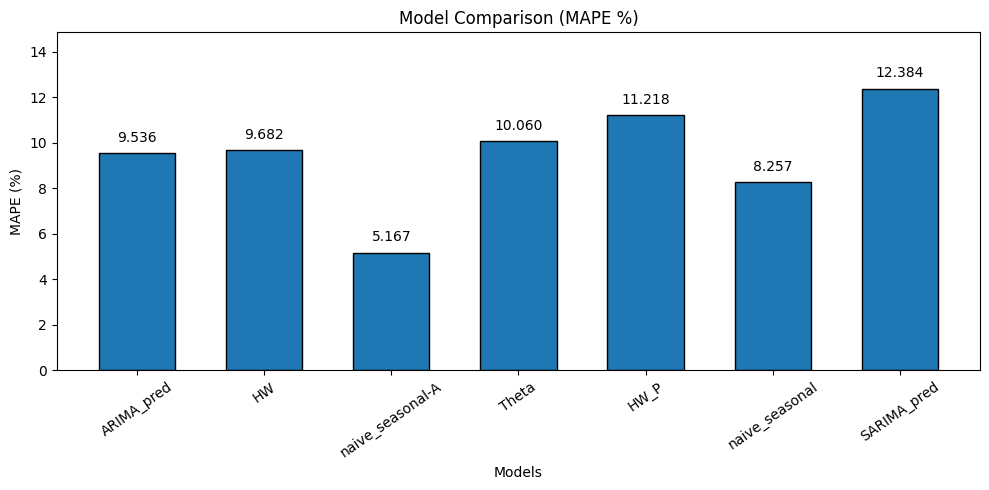

{'ARIMA_pred': np.float64(9.536064444709458),
 'HW': np.float64(9.681609917330046),
 'naive_seasonal-A': np.float64(5.167012006840521),
 'Theta': np.float64(10.059718670832877),
 'HW_P': np.float64(11.218309184821146),
 'naive_seasonal': np.float64(8.257200099226832),
 'SARIMA_pred': np.float64(12.383994767107854)}

In [ ]:
columns = ['ARIMA_pred','HW','naive_seasonal-A','Theta','HW_P','naive_seasonal','SARIMA_pred']
plot_model_mape(test,'Values',columns)

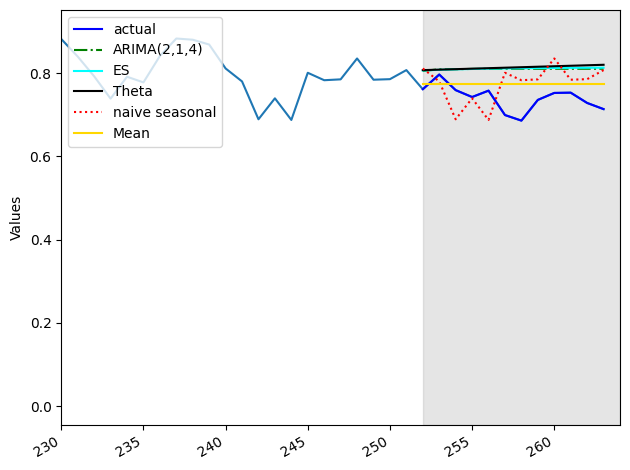

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_3)
ax.plot(test["Values"], 'b-', label='actual')
ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA(2,1,4)')
ax.plot(test['HW'], 'cyan', label='ES')
ax.plot(test['Theta'], 'black', label='Theta')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['naive_seasonal-A'] , 'gold', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(230, 264)

fig.autofmt_xdate()
plt.tight_layout()

# Métricas finais

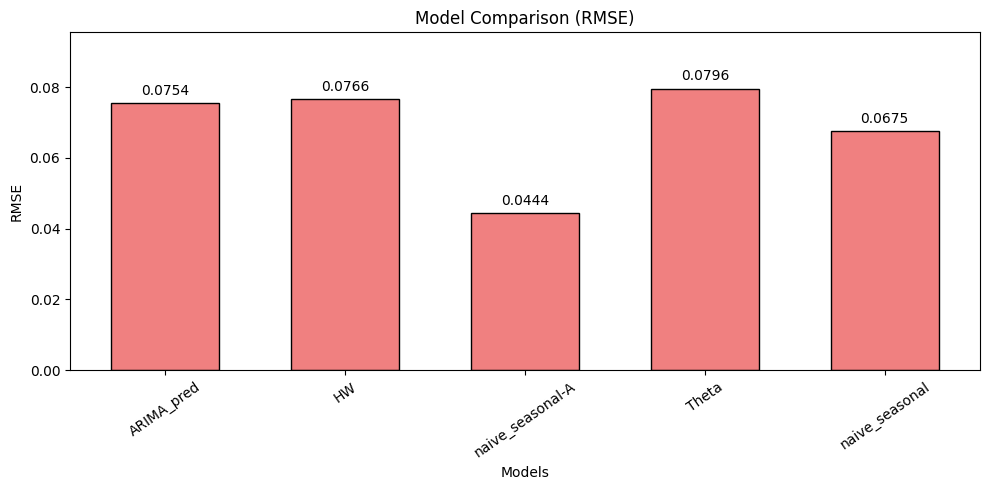

{'ARIMA_pred': np.float64(0.07540869508000349),
 'HW': np.float64(0.07661695248195452),
 'naive_seasonal-A': np.float64(0.04437649760355143),
 'Theta': np.float64(0.07955308771800956),
 'naive_seasonal': np.float64(0.06751636638195849)}

In [ ]:
test['naive_seasonal-A'] = serie_3.iloc[-24:-12].mean()
columns = ['ARIMA_pred','HW','naive_seasonal-A','Theta','naive_seasonal']
plot_model_rmse(test,'Values',columns)

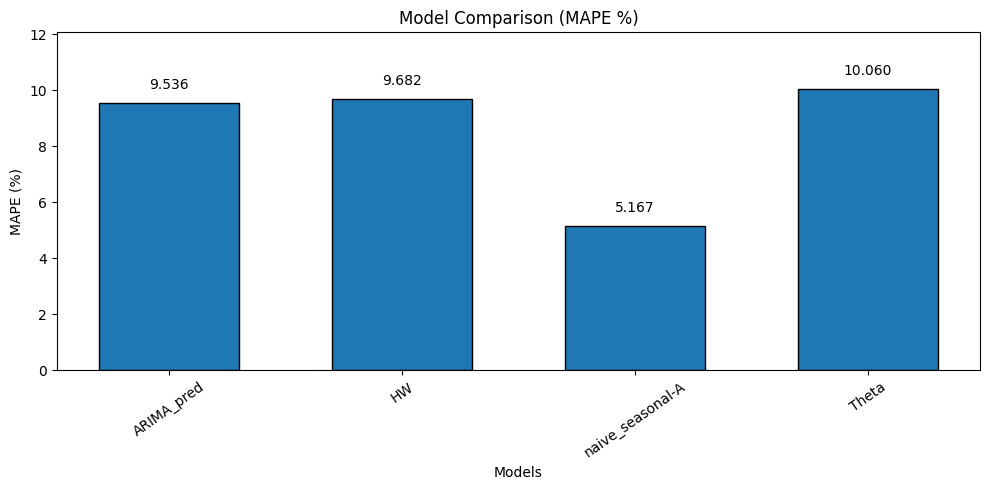

{'ARIMA_pred': np.float64(9.536064444709458),
 'HW': np.float64(9.681609917330046),
 'naive_seasonal-A': np.float64(5.167012006840521),
 'Theta': np.float64(10.059718670832877)}

In [ ]:
columns = ['ARIMA_pred','HW','naive_seasonal-A','Theta']
plot_model_mape(test,'Values',columns)

# Previsão para a série (próximos 12 meses)

In [ ]:
forecast_mean = [serie_3.iloc[-11:].mean()]*11
# ----- Salvando previsões numeradas em um .txt -----
horizon = len(forecast_mean)  # ou 11, se já definido

with open("3.csv", "w") as f:
    for i, value in enumerate(forecast_mean, 1):
        f.write(f"{value:};\n")